# Custom logistic regression

## 1. Imports

Importem les llibreries necessàries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, f1_score, roc_auc_score, precision_score, 
                              recall_score, balanced_accuracy_score, 
                              average_precision_score, confusion_matrix, roc_curve)

## 2. Custom regressió logística 

Definim la classe `CustommLogisticRegression`. 

A continuació una breu descripció dels atributs de la classe:
- `learning_rate`: taxa d'aprenentatge del descens del gradient.
- `n_epochs`: nombre de passades sobre el conjunt d'entrenament.
- `batch_size`: mida del mini-batch per a l'actualització de pesos.
- `class_weight`: permet ajustar el pes de la classe minoritària, mateix estil que l'atribut de sklearn.
- `l2_reg`: coeficient de regularització.
- `random_state`: llavor de la inicialització.

Els mètodes implementats són els seguents:
- `sigmoid`: aplica la funció sigmoide amb `np.clip` per evitar desbordaments numèrics.
- `compute_weights`: calcula un factor de pes per a la classe positiva quan `class_weight = 'balanced'`.
- `fit`: inicialitza els pesos amb valors petits aleatoris i el bias a 0. Per a cada època, barreja les mostres i recorre les dades en mini-batches. Per a cada batch, calcula la combinació lineal, els gradients i actualitza els pesos i bias.



In [2]:
class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        learning_rate=0.01,
        n_epochs=100,
        batch_size=32,
        class_weight='balanced',
        l2_reg=0.0,              
        random_state=42
    ):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.class_weight = class_weight
        self.l2_reg = l2_reg
        self.random_state = random_state
        
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def _compute_weights(self, y):
        if self.class_weight == 'balanced':
            n_samples = len(y)
            counts = np.bincount(y)
            return (n_samples / (2 * counts))[1] / (n_samples / (2 * counts))[0]
        return 1.0

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Inicialització
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0

        pos_weight = self._compute_weights(y)

        X_data = np.array(X)
        y_data = np.array(y)

        for epoch in range(self.n_epochs):
            X_shuffled, y_shuffled = shuffle(
                X_data, y_data, random_state=self.random_state + epoch
            )

            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                # Forward
                linear_model = np.dot(X_batch, self.weights) + self.bias
                y_pred = self._sigmoid(linear_model)

                error = y_pred - y_batch

                if self.class_weight == 'balanced':
                    weights_vector = np.ones_like(y_batch)
                    weights_vector[y_batch == 1] = pos_weight
                    error *= weights_vector

                # Gradient base
                dw = (1 / len(X_batch)) * np.dot(X_batch.T, error)
                db = (1 / len(X_batch)) * np.sum(error)

                # REGULARITZACIÓ L2 
                if self.l2_reg > 0:
                    dw += self.l2_reg * self.weights

                # Update
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

        return self

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        prob = self._sigmoid(linear_model)
        return np.column_stack((1 - prob, prob))

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= threshold).astype(int)


## 3. Carregar dades

Carreguem les dades e identifiquem les característiques categòriques de les numèriques.

In [3]:

# Carreguem el fitxer
df = pd.read_csv('trs_train.csv') # Asumint que aquest és el nom del fitxer, sinó canvia-ho

# Separem Features i Target
X = df.drop(['TRS', 'patient_id', 'Ki_associative_striatum', 'SUVRc_associative_striatum', 'Glucose'], axis=1) # Eliminem ID i Target
y = df['TRS']

# Definició de columnes basades en l'EDA
# Variables Categòriques (Strings o amb pocs nivells numèrics que actuïn com a categories)
cat_features = ['Sex', 'Ethnicity', 'Family_history', 'Prior_antipsychotics', 
                'CYP2D6_metabolic_phenotype', 'HLA_DRB1_04_02', 'HLA_B_15_02', 
                'HLA_A_31_01', 'Del_22q11_2_status']

# Totes les altres són numèriques
num_features = [col for col in X.columns if col not in cat_features]

## 4. Preprocessament

Aquí tenim el pipeline de preprocessament.

Per a les variables numèriques, imputem amb la mediana, utilitzant la funció `SimpleImputer` de sklearn. Escalem també les dades amb `StandardScaler`, de la mateixa llibreria.

Per a les variables categòriques, imputem amb el valor més frequent, utilitzant la funció `SimpleImmputer`. Codifiquem també amb `OneHotEncoder`.

In [4]:

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

## 5. Cross Validation

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CustomLogisticRegression(class_weight='balanced', random_state=42))
])


param_grid = {
    'classifier__l2_reg': [0.001, 0.01, 0.1],
    'classifier__learning_rate': [0.001, 0.005, 0.01, 0.1],
    'classifier__batch_size': [32, 64, 128, 256, 512],
    'classifier__n_epochs': [50, 100, 150, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=cv,
    n_jobs=-1,     
    verbose=1,     
    return_train_score=True
)

print("Iniciant cerca d'hiperparàmetres (Grid Search CV)...")
grid_search.fit(X_train, y_train)



Iniciant cerca d'hiperparàmetres (Grid Search CV)...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


,estimator,Pipeline(step...egression())])
,param_grid,"{'classifier__batch_size': [32, 64, ...], 'classifier__l2_reg': [0.001, 0.01, ...], 'classifier__learning_rate': [0.001, 0.005, ...], 'classifier__n_epochs': [50, 100, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...), ('cat', ...)]"


## 6. Anàlisi de resultats

Immprimim els millor hiperparàmetres i el millor F1-macro.

In [6]:

# Millors paràmetres trobats
best_model = grid_search.best_estimator_
print(f"\nMillors hiperparàmetres trobats: {grid_search.best_params_}")
print(f"Millor F1-macro: {grid_search.best_score_:.4f}")



Millors hiperparàmetres trobats: {'classifier__batch_size': 512, 'classifier__l2_reg': 0.001, 'classifier__learning_rate': 0.001, 'classifier__n_epochs': 150}
Millor F1-macro: 0.5971


Imprimim el classification report per veure les mètriques del nostre model.

In [7]:
print("\n" + "=" * 80)
print("EVALUACIÓN DEL MODELO")
print("=" * 80)

# Predicciones
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No TRS', 'TRS']))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")




EVALUACIÓN DEL MODELO

--- Classification Report ---
              precision    recall  f1-score   support

      No TRS       0.74      0.67      0.70      1232
         TRS       0.41      0.50      0.45       568

    accuracy                           0.61      1800
   macro avg       0.58      0.58      0.58      1800
weighted avg       0.64      0.61      0.62      1800


ROC-AUC Score: 0.6291


c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Visualitzem la matriu de confusió i la corba ROC del nostre model.

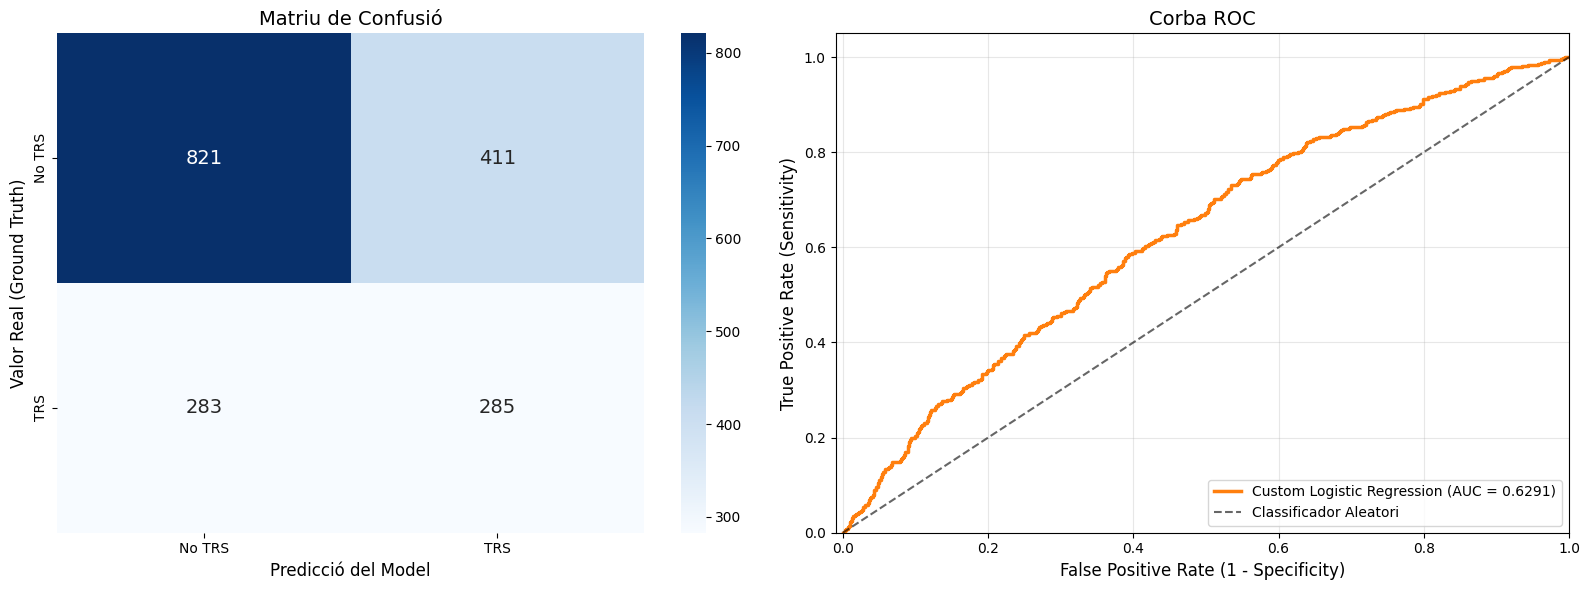


ROC-AUC correcte: 0.6291


In [8]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------------------------------------------------------
# 1. MATRIU DE CONFUSIÓ
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 14})
axes[0].set_title('Matriu de Confusió', fontsize=14)
axes[0].set_ylabel('Valor Real (Ground Truth)', fontsize=12)
axes[0].set_xlabel('Predicció del Model', fontsize=12)
axes[0].set_xticklabels(['No TRS', 'TRS'])
axes[0].set_yticklabels(['No TRS', 'TRS'])

# ---------------------------------------------------------
# 2. CORBA ROC
# ---------------------------------------------------------
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

axes[1].plot(fpr, tpr, label=f'Custom Logistic Regression (AUC = {roc_auc:.4f})', 
             color='#ff7f0e', linewidth=2.5)

axes[1].plot([0, 1], [0, 1], 'k--', label='Classificador Aleatori', alpha=0.6)

axes[1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
axes[1].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
axes[1].set_title('Corba ROC', fontsize=14)
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)
axes[1].set_xlim([-0.01, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print(f"\nROC-AUC correcte: {roc_auc:.4f}")


Visualitzemm un gràfic on podem comparar el F1-macro del nostre model depenent de la mida del mini-batch.

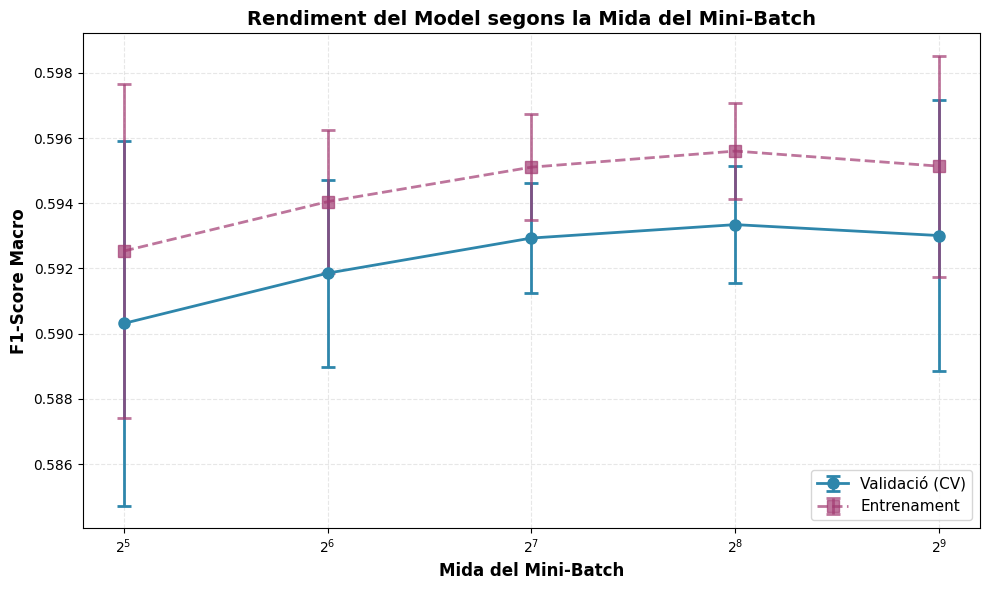

In [10]:


results_df = pd.DataFrame(grid_search.cv_results_)

# Agrupar per batch_size i calcular la mitjana i desviació estàndard del F1-macro
batch_analysis = results_df.groupby('param_classifier__batch_size').agg({
    'mean_test_score': ['mean', 'std'],
    'mean_train_score': ['mean', 'std']
}).reset_index()

# Simplificar els noms de les columnes
batch_analysis.columns = ['batch_size', 'test_mean', 'test_std', 'train_mean', 'train_std']

# Ordenar per batch_size
batch_analysis = batch_analysis.sort_values('batch_size')

# Crear el gràfic
plt.figure(figsize=(10, 6))

# Plot amb barres d'error
plt.errorbar(batch_analysis['batch_size'], batch_analysis['test_mean'], 
             yerr=batch_analysis['test_std'], 
             marker='o', linestyle='-', linewidth=2, markersize=8,
             capsize=5, capthick=2, label='Validació (CV)', color='#2E86AB')

plt.errorbar(batch_analysis['batch_size'], batch_analysis['train_mean'], 
             yerr=batch_analysis['train_std'], 
             marker='s', linestyle='--', linewidth=2, markersize=8,
             capsize=5, capthick=2, label='Entrenament', color='#A23B72', alpha=0.7)

# Configuració del gràfic
plt.xlabel('Mida del Mini-Batch', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score Macro', fontsize=12, fontweight='bold')
plt.title('Rendiment del Model segons la Mida del Mini-Batch', fontsize=14, fontweight='bold')
plt.xscale('log', base=2)  # Escala logarítmica base 2 per millor visualització
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()


Visualitzem un gràfic per comparar les mètriques d'avaluació en el conjunt d'entrenament i en el conjunt de validació.

c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Usuario\Documents\UPC\Segon\IAA\Lliurable Laboratori\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 


COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)
Mètrica                   Train        Test         Diferència  
----------------------------------------------------------------------
F1-Macro                       0.5982      0.5769      0.0213
F1-Binary (TRS)                0.4746      0.4509      0.0237
ROC-AUC                        0.6498      0.6291      0.0207
PR-AUC                         0.4450      0.4169      0.0281
Recall (TRS)                   0.5211      0.5018      0.0194
Precision (TRS)                0.4357      0.4095      0.0262
Balanced Accuracy              0.6052      0.5841      0.0211


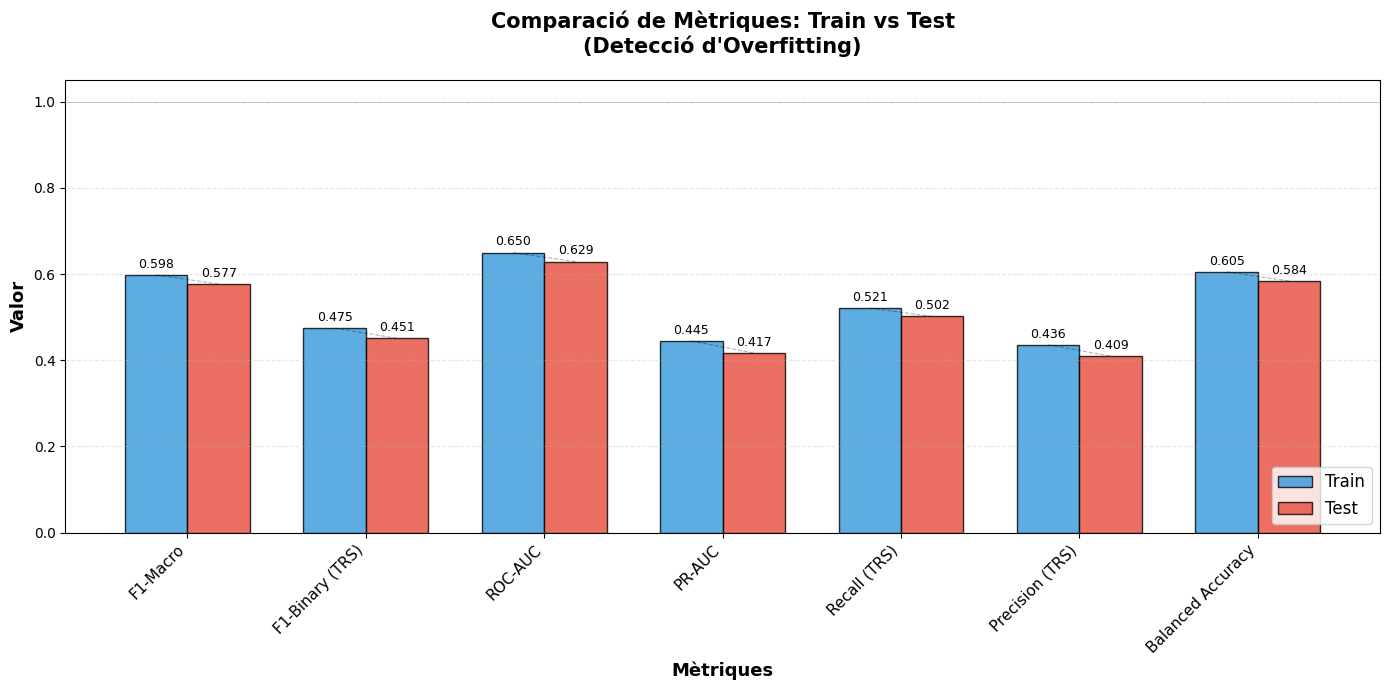

In [12]:


# Calcular prediccions per al conjunt de train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Calcular prediccions per al conjunt de test (ja les tens)
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular mètriques per train
train_metrics = {
    'F1-Macro': f1_score(y_train, y_train_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_train, y_train_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_train, y_train_pred_proba),
    'PR-AUC': average_precision_score(y_train, y_train_pred_proba),
    'Recall (TRS)': recall_score(y_train, y_train_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_train, y_train_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_train, y_train_pred)
}

# Calcular mètriques per test
test_metrics = {
    'F1-Macro': f1_score(y_test, y_test_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_test, y_test_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_test_pred_proba),
    'Recall (TRS)': recall_score(y_test, y_test_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_test, y_test_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_test_pred)
}

# Mostrar mètriques per pantalla
print("\n" + "="*70)
print("COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)")
print("="*70)
print(f"{'Mètrica':<25} {'Train':<12} {'Test':<12} {'Diferència':<12}")
print("-" * 70)

for metric_name in train_metrics.keys():
    train_val = train_metrics[metric_name]
    test_val = test_metrics[metric_name]
    diff = train_val - test_val
    print(f"{metric_name:<25} {train_val:>11.4f} {test_val:>11.4f} {diff:>11.4f}")

# Visualització amb gràfic de barres agrupades
fig, ax = plt.subplots(figsize=(14, 7))

metrics_names = list(train_metrics.keys())
train_values = list(train_metrics.values())
test_values = list(test_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, train_values, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_values, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Afegir línies per mostrar diferències
for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
    if train_val > test_val:
        ax.plot([i - width/2, i + width/2], [train_val, test_val], 
                'k--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Mètriques', fontsize=13, fontweight='bold')
ax.set_ylabel('Valor', fontsize=13, fontweight='bold')
ax.set_title('Comparació de Mètriques: Train vs Test\n(Detecció d\'Overfitting)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=1.0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Afegir valors sobre les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


